# util func

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def merge_onehot_columns(X_array, preprocess_transformer, original_col):
    
    feature_names = preprocess_transformer.get_feature_names_out()
    X_df = pd.DataFrame(X_array, columns=feature_names)

    prefix = f"onehot_encoder__{original_col}_"
    onehot_cols = [c for c in X_df.columns if c.startswith(prefix)]
    
    if len(onehot_cols) == 0:
        raise ValueError("Colunas one-hot não encontradas.")

    categories = [c.replace(prefix, "") for c in onehot_cols]

    idx = X_df[onehot_cols].values.argmax(axis=1)

    X_df[original_col] = np.array(categories)[idx]

    X_df = X_df.drop(columns=onehot_cols)

    return X_df


def revert_ordinal_column(X_array, preprocess_transformer, original_col):
    
    feature_names = preprocess_transformer.get_feature_names_out()
    X_df = pd.DataFrame(X_array, columns=feature_names)

    col_name = f"ordinal_encoder__{original_col}"
    
    ord_enc = preprocess_transformer.named_transformers_["ordinal_encoder"]
    
    ord_cols = preprocess_transformer.transformers_[1][2]
    col_idx = ord_cols.index(original_col)
    
    categories = ord_enc.categories_[col_idx]
    
    col_values = X_df[col_name].astype(int).values
    col_values = np.clip(col_values, 0, len(categories) - 1)
    
    X_df[original_col] = categories[col_values]
    
    X_df = X_df.drop(columns=[col_name])
    
    return X_df

def revert_preprocessing():

    for model in synth_data.keys():

        new_df = pd.DataFrame()
        for feat in cat_cols:
            merged_col = merge_onehot_columns(
                X_array=synth_data[model]["x"],
                preprocess_transformer=preprocess_transformer,
                original_col=feat
            )[feat]
            new_df[feat] = merged_col

        merged_col = revert_ordinal_column(
            X_array=synth_data[model]["x"],
            preprocess_transformer=preprocess_transformer,
            original_col="class_etaria"
        )["class_etaria"]
        new_df["class_etaria"] = merged_col


        feature_names = preprocess_transformer.get_feature_names_out()
        imc_idx = list(feature_names).index("remainder__imc")

        imc = synth_data[model]["x"][:, imc_idx]

        new_df["imc"] = imc

        synth_data[model]["x"] = new_df



# ...

In [44]:

features = [
    "genero", # categorica nominal
    "estado_civil", # categorica nominal
    "zona_residencia", # categorica nominal
    "imc", # numerica continua
    "fumador",  # categorica nominal
    "class_etaria", # categorica ordinal
    #"custo" # numerica continua
]

feature_value_names = [
    "Género",
    "Estado Civil",
    "Tipo da área de esidência",
    "Índice de Massa Corporal",
    "É Fumador",
    "Faixa Etária",
    #"valor do custo"
]

# ==========================
ratio = "1.00"
filename = "synth data custo 1.0.pkl"
# ==========================



dataset_path = "../../../../datasets/custo_seguro.csv"
base_path = f"ratio {ratio}"
load_path = f"{base_path}/{filename}"

In [45]:

import pandas as pd
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

df = pd.read_csv(dataset_path)
df = df.rename(columns={'custo': 'Target'})

X = df.drop(columns={"Target"})
y = df["Target"]

cat_cols = [c for c in X.columns if X[c].dtype == 'object' or str(X[c].dtype).startswith('category')]
num_cols = [c for c in X.columns if c not in cat_cols]

ord_cols = []

if "class_etaria" in cat_cols:
    ord_cols.append("class_etaria")
    cat_cols.remove("class_etaria")

onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
ordinal_encoder = OrdinalEncoder().set_output(transform="pandas")

preprocess_transformer = ColumnTransformer(
    transformers=[("onehot_encoder", onehot_encoder, cat_cols),
                    ("ordinal_encoder", ordinal_encoder, ord_cols)],
    remainder="passthrough"
)
preprocess_transformer.fit_transform(X)
#X = preprocess_transformer.fit_transform(X)
#y = y.to_numpy()

import pickle
with open(load_path , "rb") as f:
    synth_data = pickle.load(f)
    print(synth_data.keys())

revert_preprocessing()

n_features = X.shape[1]

dict_keys(['GAN', 'CTGAN', 'COPULAGAN', 'VAE', 'TVAE', 'DDPM'])


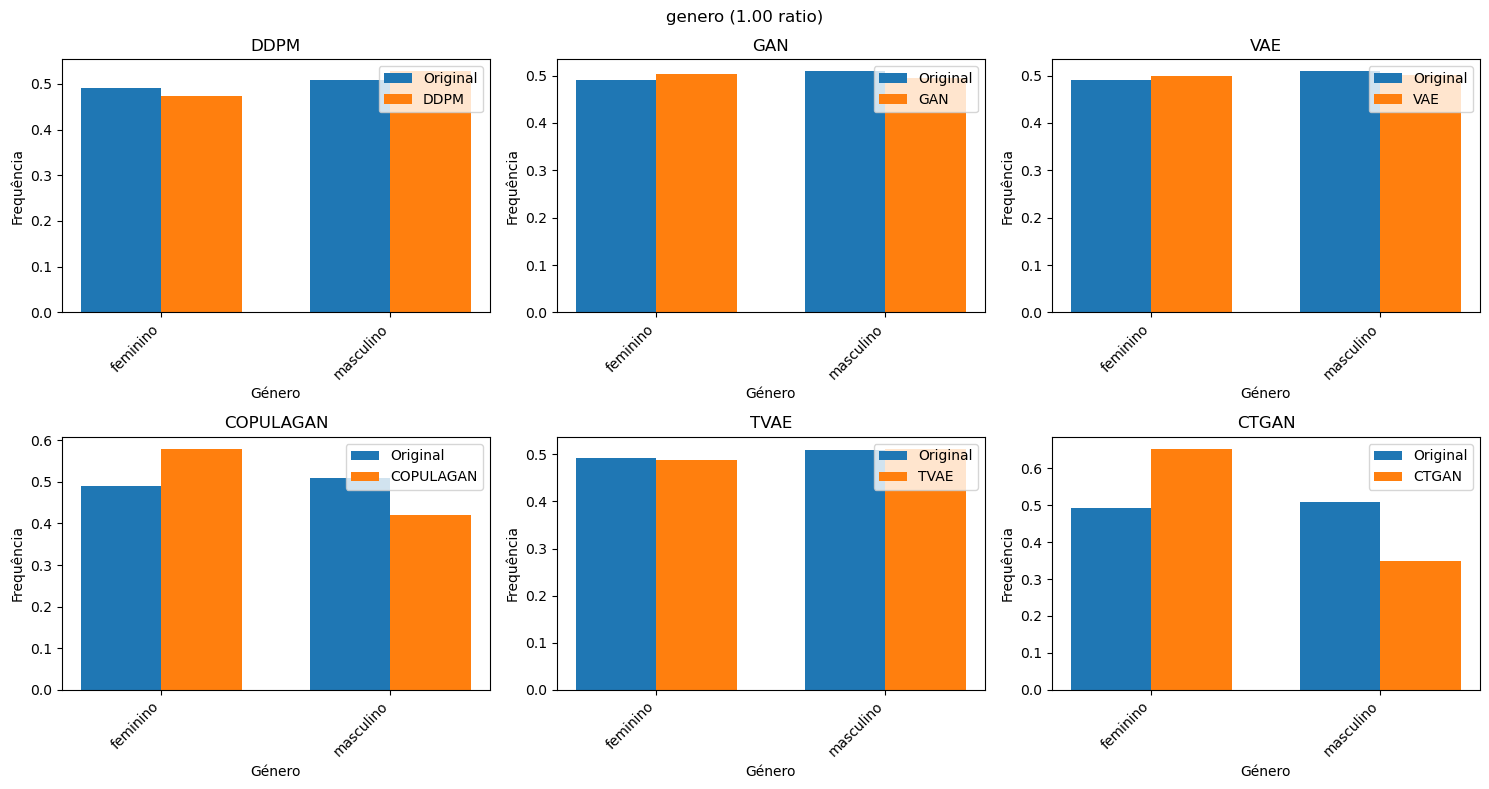

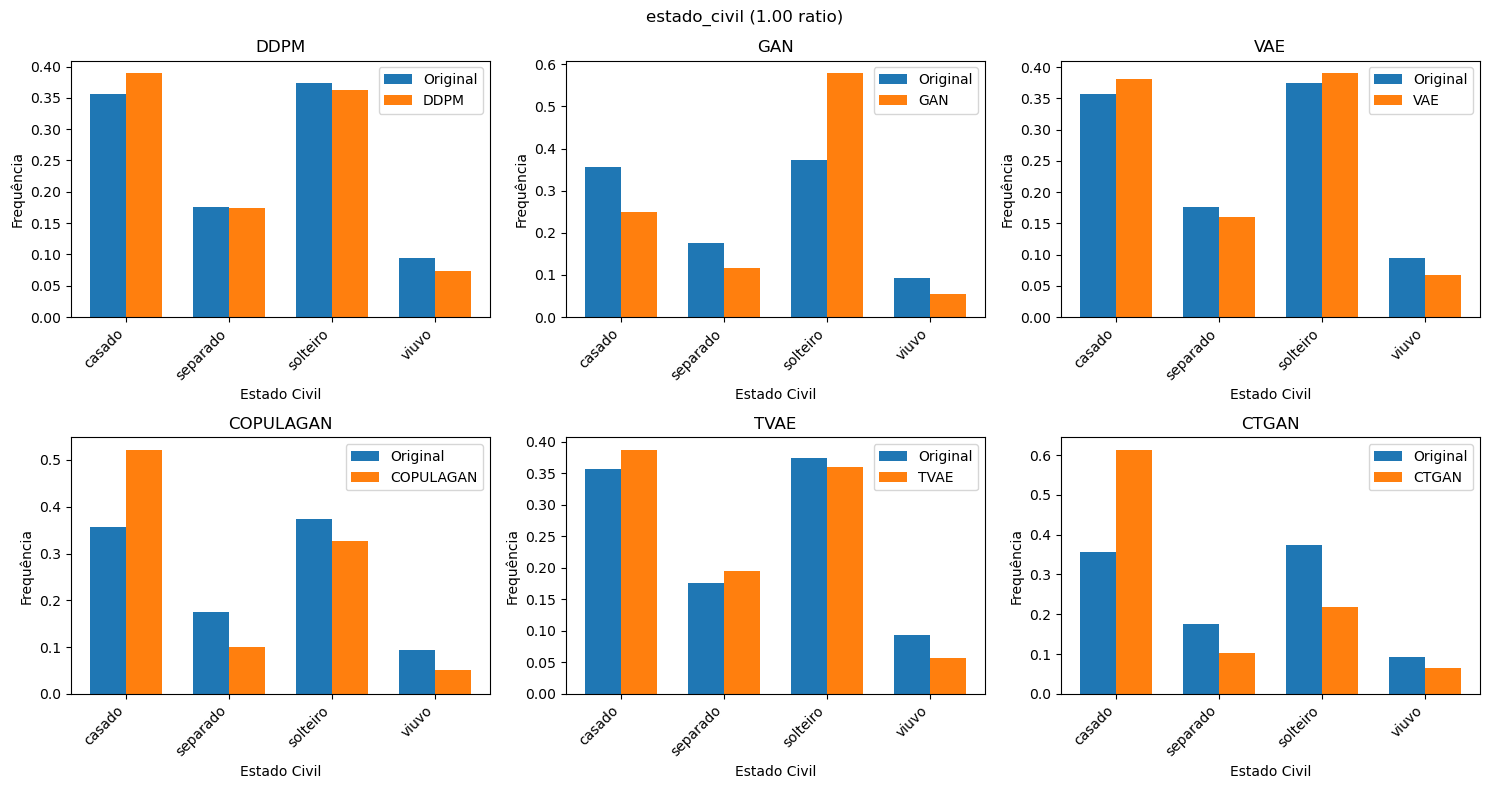

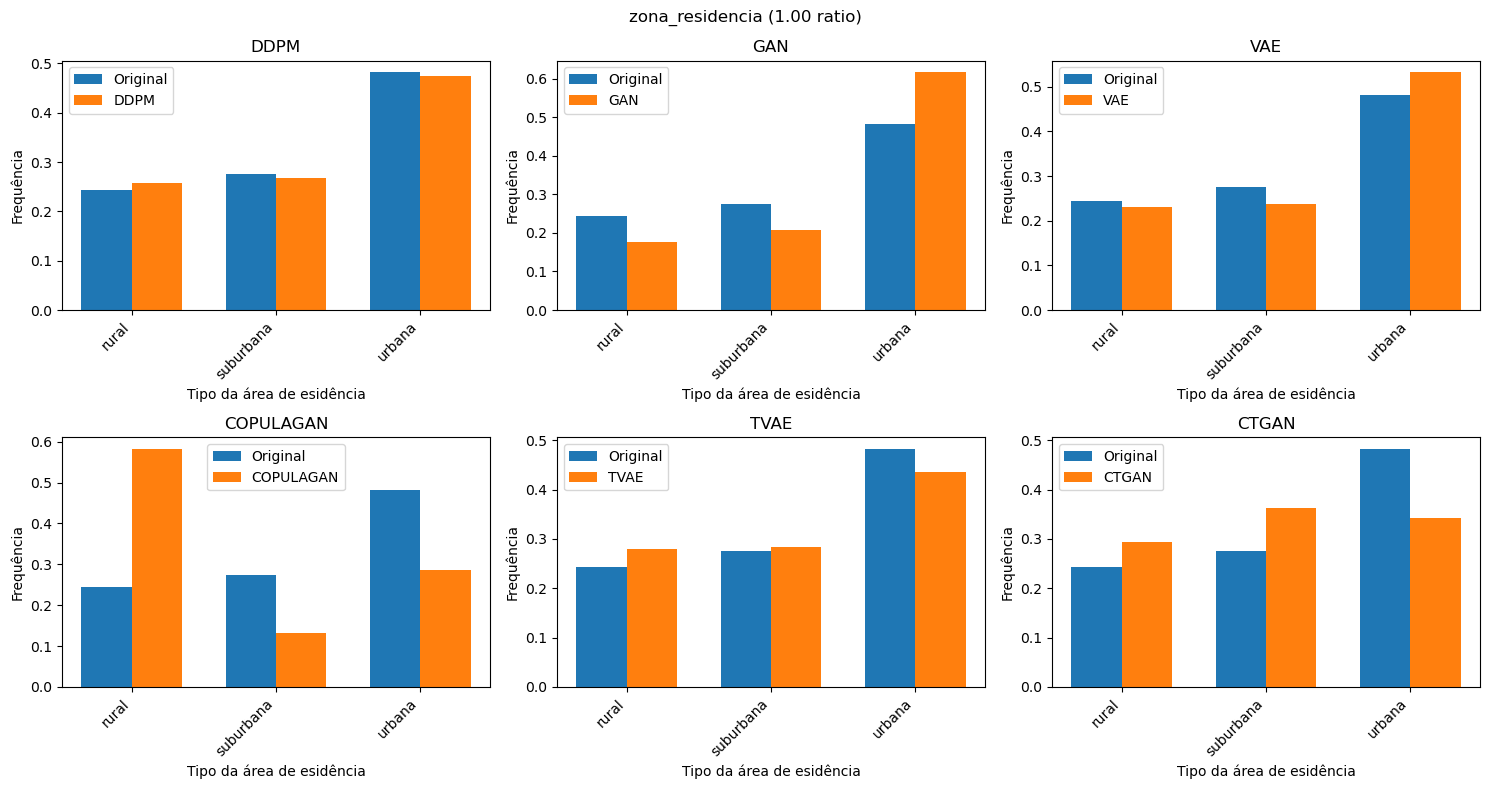

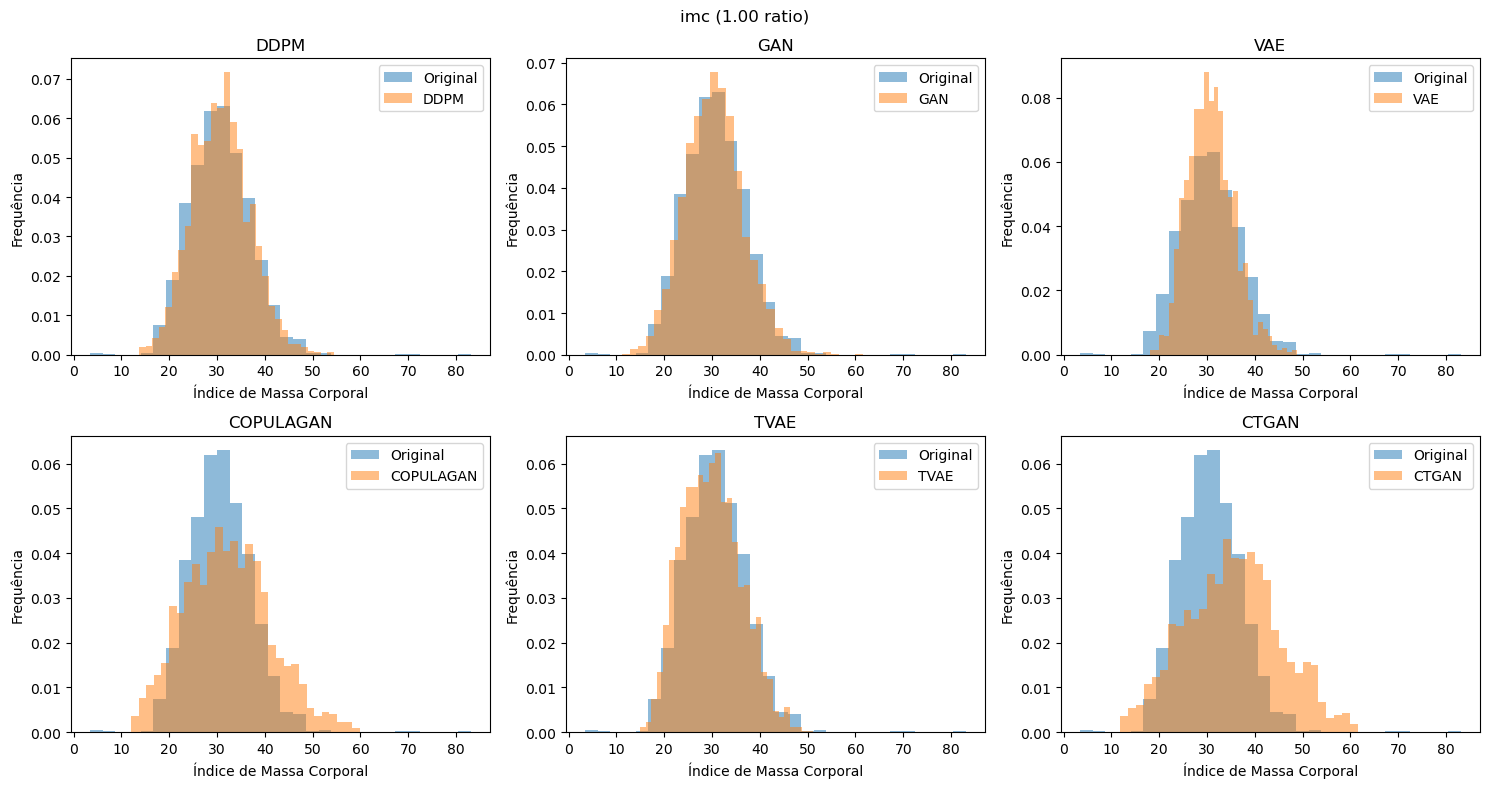

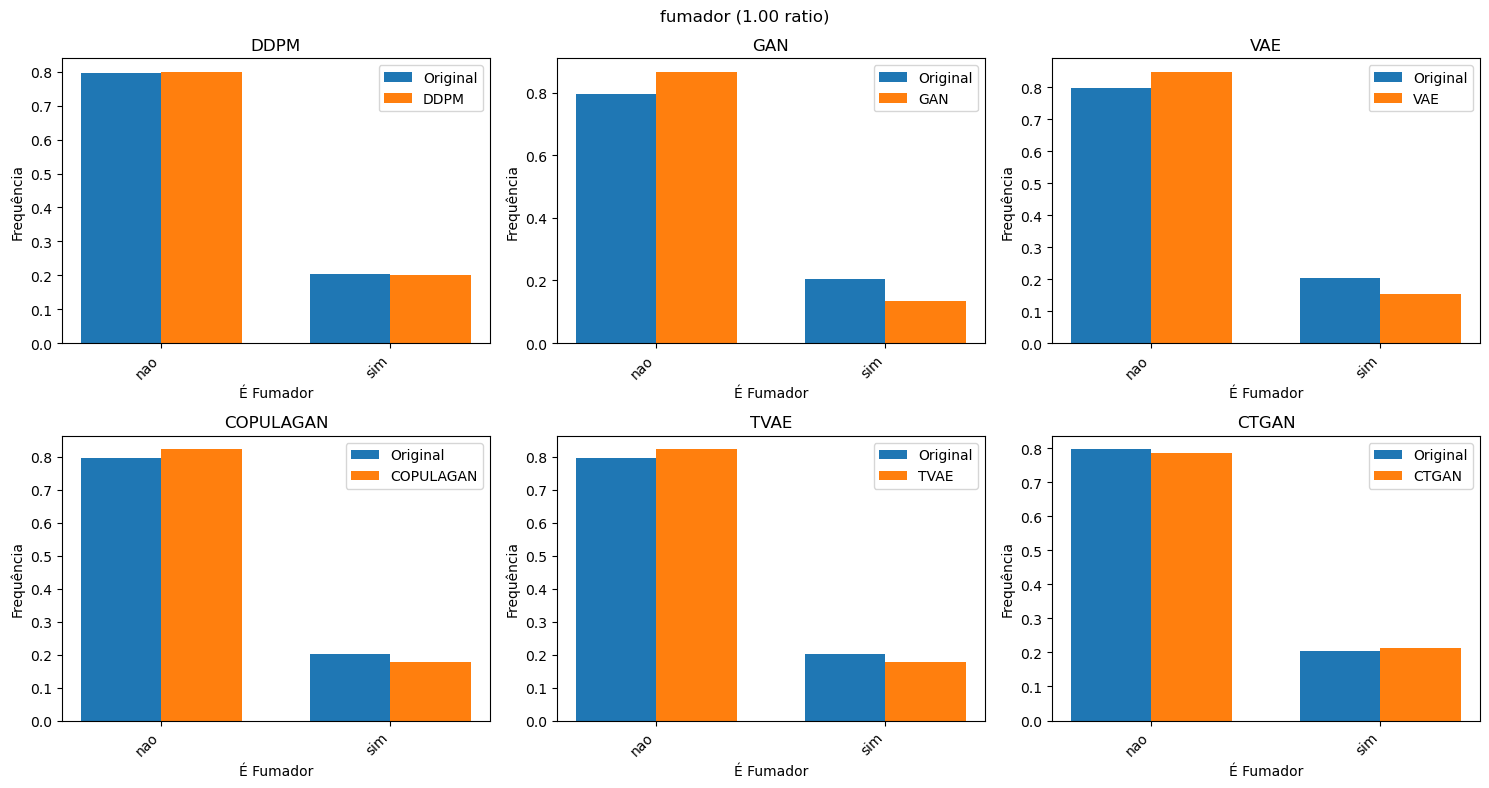

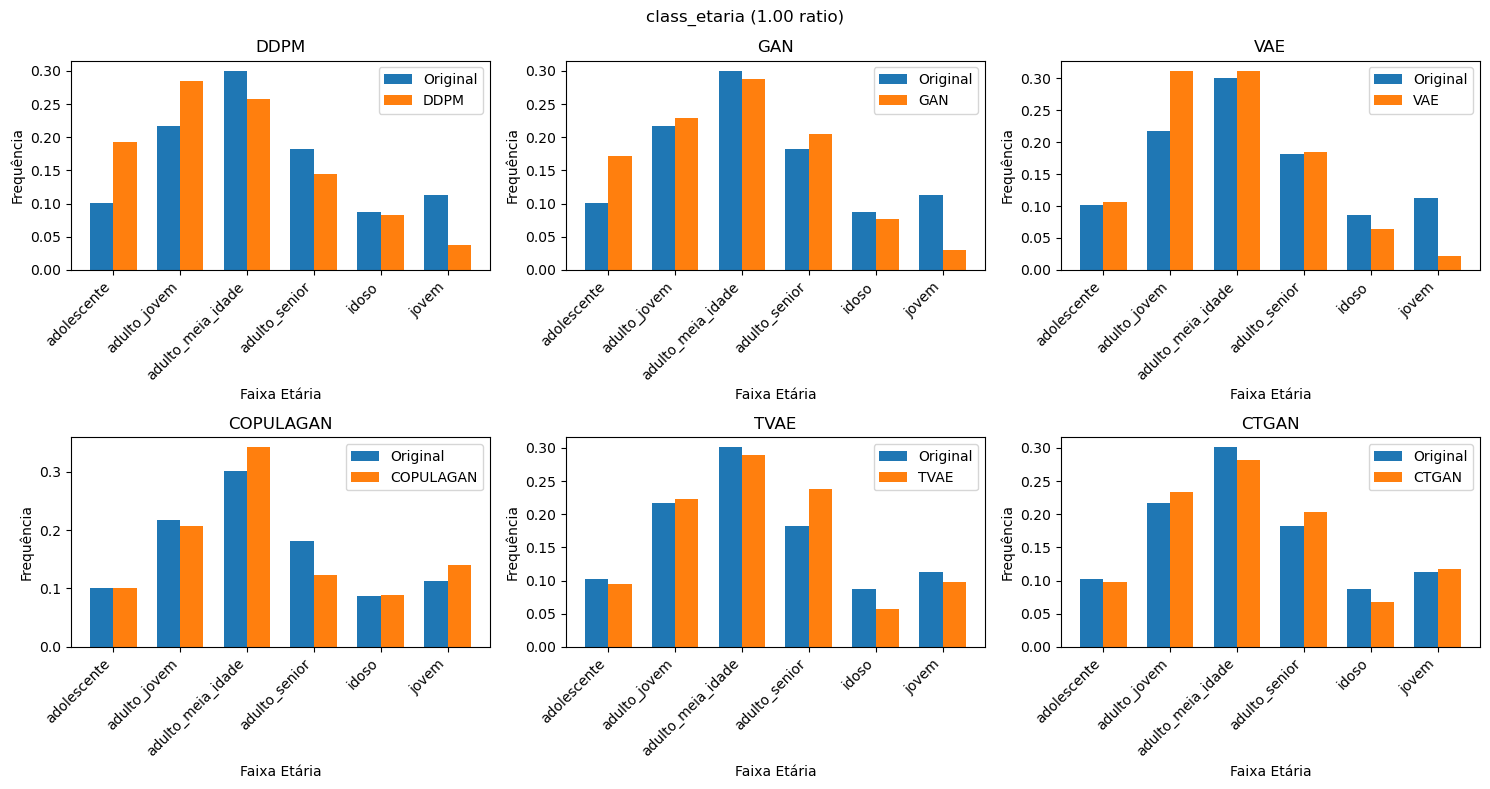

In [46]:
import matplotlib.pyplot as plt
import numpy as np

models = {
    "DDPM": synth_data["DDPM"]["x"],
    "GAN": synth_data["GAN"]["x"],
    "VAE": synth_data["VAE"]["x"],
    "COPULAGAN": synth_data["COPULAGAN"]["x"],
    "TVAE": synth_data["TVAE"]["x"],
    "CTGAN": synth_data["CTGAN"]["x"],
}

x_axis_names = feature_value_names
y_axis_names = ["Frequência"] * n_features

i = 0
for feature in features:

    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()

    for ax, (name, data) in zip(axes, models.items()):

        if feature in cat_cols or feature in ord_cols:

            real_counts = X[feature].value_counts(normalize=True)
            synth_counts = data[feature].value_counts(normalize=True)

            all_categories = sorted(
                set(real_counts.index) | set(synth_counts.index)
            )

            real_vals = [real_counts.get(cat, 0) for cat in all_categories]
            synth_vals = [synth_counts.get(cat, 0) for cat in all_categories]

            x = np.arange(len(all_categories))
            width = 0.35

            ax.bar(x - width/2, real_vals, width, label="Original")
            ax.bar(x + width/2, synth_vals, width, label=name)

            ax.set_xticks(x)
            ax.set_xticklabels(all_categories, rotation=45, ha="right")

        else:
            ax.hist(X[feature], bins=30, density=True, alpha=0.5, label="Original")
            ax.hist(data[feature], bins=30, density=True, alpha=0.5, label=name)

        ax.set_title(name)
        ax.set_xlabel(x_axis_names[i])
        ax.set_ylabel(y_axis_names[i])
        ax.legend()

    fig.suptitle(f"{feature} ({ratio} ratio)")
    plt.tight_layout()
    image_filename = f"synth ratio {ratio} {feature}.png"
    plt.savefig(f"{base_path}/{image_filename}")
    plt.show()

    i += 1